In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import scipy as sc 
import numpy as np
import cvxpy as cvx

import sys
import os
import importlib

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import covariance_functions.general_functions as gf
import covariance_functions.em_functions as em
import covariance_functions.ewma_functions as ewma
import covariance_functions.regularization_functions as reg
import covariance_functions.backtest_functions as bt
import covariance_functions.portfolio_functions as pf
import covariance_functions.tradingmodel_functions as tm


print(f"import start")
importlib.reload(gf)
importlib.reload(em)
importlib.reload(ewma)
importlib.reload(reg)
importlib.reload(bt)
importlib.reload(pf)
importlib.reload(tm)
print(f"import end")

from covariance_functions.em_functions import *
from covariance_functions.ewma_functions import *
from covariance_functions.ewma_functions import _ewma_cov
from covariance_functions.ewma_functions import iterated_ewma
from covariance_functions.general_functions import *
from covariance_functions.regularization_functions import *
from covariance_functions.backtest_functions import *
from covariance_functions.portfolio_functions import *
from covariance_functions.tradingmodel_functions import *
from covariance_functions.tradingmodel_functions import Trader




import start
import end


# Import Data and Data Pre-Processing

In [78]:
returns = pd.read_csv('data/returns_large_universe.csv')
returns = returns.set_index('date')
returns = returns.rename_axis('Date', axis='index')
returns.index = pd.to_datetime(returns.index, format='%Y-%m-%d')

FF = pd.read_csv('data/ff5.csv')
FF = FF.set_index('Unnamed: 0')
FF = FF.rename_axis('Date', axis='index')
FF.index = pd.to_datetime(FF.index, format='%Y-%m-%d')

rf_rate = pd.DataFrame(FF.loc[:,"RF"])
rf_rate.index = pd.to_datetime(rf_rate.index, format='%Y%m%d')

In [79]:
mapping_data=pd.read_csv('data/permno_to_ticker_mapping.csv')
mapping_df = pd.DataFrame(mapping_data)
returns.columns = returns.columns.astype(str)
permno_to_ticker = dict(zip(mapping_df['PERMNO'].astype(str), mapping_df['tic']))
returns.rename(columns=permno_to_ticker, inplace=True)

In [80]:
returns

,MSFT,GE,CSCO,WMT,INTC,XOM,IBM,C,ORCL,T,...,FE,AB,HBAN,HSY,HES,CINF,ECL,SKM,ZION,NUE
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,-0.001606,-0.030695,0.008751,-0.032550,0.056948,-0.029480,0.071842,-0.050505,0.054099,-0.032051,...,-0.027548,-0.006263,-0.060209,-0.022398,-0.039648,-0.021042,-0.036741,0.009772,-0.062302,-0.009122
2000-01-04,-0.033780,-0.038750,-0.056102,-0.039252,-0.046695,-0.017586,-0.030811,-0.042553,-0.088360,-0.062252,...,0.000000,-0.004202,-0.030641,-0.037736,-0.019495,-0.001024,-0.026534,-0.103226,-0.048423,-0.010357
2000-01-05,0.010544,-0.005202,-0.003064,-0.019455,0.008289,0.054516,0.035137,0.003704,-0.052815,0.015537,...,0.036827,0.004219,-0.025862,0.004202,-0.008187,0.010246,0.039182,-0.028777,-0.001183,0.027907
2000-01-06,-0.033498,0.015577,-0.016595,0.010913,-0.058296,0.049383,-0.008621,0.065191,-0.058824,-0.021001,...,0.002732,0.016807,0.035398,0.026499,0.021226,0.006085,0.044262,-0.007407,0.014218,0.009050
2000-01-07,0.013068,0.038721,0.058750,0.075564,0.041270,-0.000735,-0.013043,-0.002309,0.076823,0.008571,...,0.005450,0.033058,0.008547,0.002717,0.042725,0.020161,0.000000,0.123134,0.002336,0.003363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,0.002267,0.000245,0.003381,0.002021,0.004621,0.026445,0.005466,0.006138,0.004473,0.002189,...,0.014493,-0.015795,0.010065,0.004044,0.047154,0.006843,0.010416,0.010531,0.003521,-0.006062
2022-12-27,-0.007414,0.012838,0.001053,0.000278,-0.005749,0.013894,0.005436,0.002937,0.001608,0.008192,...,0.006190,-0.005544,-0.000712,-0.000636,0.012211,-0.000191,0.006296,0.011843,0.008050,0.003380
2022-12-28,-0.010255,-0.010502,-0.009678,-0.017523,-0.015420,-0.016426,-0.016852,0.005181,-0.008027,-0.013001,...,-0.004496,-0.027876,-0.004274,-0.012133,-0.033261,-0.016565,-0.011344,-0.015918,-0.017813,-0.017211


In [81]:
mapping_data[mapping_data['tic']=='CNP']

,PERMNO,conm,tic
338,20939,CENTERPOINT ENERGY INC,CNP
339,20939,CENTERPOINT ENERGY INC,CNP


In [82]:
# csv_file_path = 'data/large_universe_data.csv'
# returns.to_csv(csv_file_path)
# csv_file_path


# Universe Composition Breakdown

In [83]:
# import requests

# API_KEY = 'DUD01JLEKMTBP5QI'

# def get_market_cap(ticker):
#     url = f'https://www.alphavantage.co/query?function=OVERVIEW&symbol={ticker}&apikey={API_KEY}'
#     response = requests.get(url).json()
#     return response.get('MarketCapitalization', None)

In [84]:
# Creating a dictionary with the tickers and their market caps
large_cap_data = {
    'Ticker': ['MSFT', 'GE', 'WMT', 'INTC', 'XOM', 'IBM', 'AAPL', 'AMZN', 'T', 'ORCL', 'BAC', 'JPM', 'PG', 'JNJ', 'KO', 'PEP', 'DIS', 'CVX', 'VZ', 'PFE'],
    'Market Cap (Billion)': [3190, 123, 648.45, 147, 520.03, 203.54, 3460, 2040, 109, 459.42, 282, 602.01, 355, 490, 258, 251, 293, 318, 142, 217]
}
mid_cap_data = {
    'Ticker': ['F', 'NOK', 'BBY', 'STT', 'IPG', 'KR', 'HOG'],
    'Market Cap (Billion)': [57, 20, 27, 34, 13, 38, 6]
}

small_cap_data = {
    'Ticker': ['GAP', 'AKAM', 'FITB', 'NWL'],
    'Market Cap (Billion)': [6, 13, 24, 6]
}

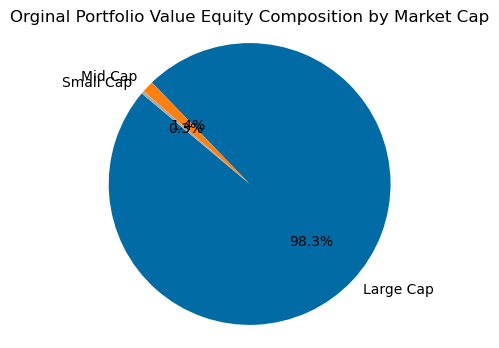

In [85]:
large_cap_total = sum([3190, 123, 648.45, 147, 520.03, 203.54, 3460, 2040, 109, 459.42, 282, 602.01, 355, 490, 258, 251, 293, 318, 142, 217])
mid_cap_total = sum([57, 20, 27, 34, 13, 38, 6])
small_cap_total = sum([6, 13, 24, 6])

categories = ['Large Cap', 'Mid Cap', 'Small Cap']
values = [large_cap_total, mid_cap_total, small_cap_total]

plt.style.use('tableau-colorblind10')

plt.figure(figsize=(4, 4))
plt.pie(values, labels=categories, autopct='%1.1f%%', startangle=140)
plt.title('Orginal Portfolio Value Equity Composition by Market Cap')
plt.axis('equal') 
plt.show()

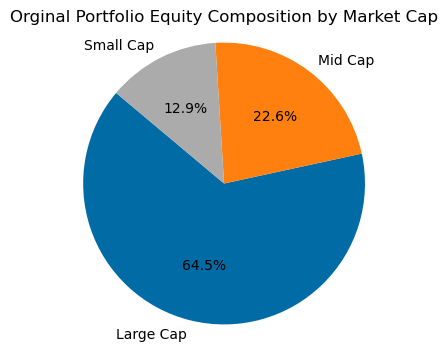

In [86]:
large_cap_total = len([3190, 123, 648.45, 147, 520.03, 203.54, 3460, 2040, 109, 459.42, 282, 602.01, 355, 490, 258, 251, 293, 318, 142, 217])
mid_cap_total = len([57, 20, 27, 34, 13, 38, 6])
small_cap_total = len([6, 13, 24, 6])

categories = ['Large Cap', 'Mid Cap', 'Small Cap']
values = [large_cap_total, mid_cap_total, small_cap_total]

plt.style.use('tableau-colorblind10')

plt.figure(figsize=(4, 4))
plt.pie(values, labels=categories, autopct='%1.1f%%', startangle=140)
plt.title('Orginal Portfolio Equity Composition by Market Cap')
plt.axis('equal') 
plt.show()

# Add More Data - REITS

In [87]:
# Real Estate (REITs) - daily return from 
reit_returns = pd.read_csv('data/REIT_data.csv')
reit_ret_df = pd.DataFrame(reit_returns)
reit_ret_df['RETX'] = pd.to_numeric(reit_ret_df['RETX'], errors='coerce')
reit_ret_df['RET'] = pd.to_numeric(reit_ret_df['RET'], errors='coerce')
reit_ret_df['date'] = pd.to_datetime(reit_ret_df['date'], format='%m/%d/%y')
reit_ret_df=reit_ret_df.dropna()
reit_ret_df = reit_ret_df.pivot(index='date', columns='TICKER', values='RET')

tickers = ['NLY', 'PLD', 'SPG']

reit = reit_ret_df.filter(items=tickers)

In [88]:
reit

TICKER,NLY,PLD,SPG
date,,,
2000-01-03,-0.042857,-0.009740,-0.013624
2000-01-04,-0.007463,-0.026230,-0.011050
2000-01-05,-0.007519,0.026936,0.008380
2000-01-06,-0.007576,0.009836,0.024931
2000-01-07,0.038168,0.003247,0.043243
...,...,...,...
2023-12-22,-0.001970,0.010996,0.000563
2023-12-26,0.011846,0.008006,0.009557
2023-12-27,0.001463,0.005395,0.000070


# Add Commod Data

In [89]:
commod = pd.read_csv('data/commod_etf.csv')
commod = pd.DataFrame(commod)
commod['RETX'] = pd.to_numeric(commod['RETX'], errors='coerce')
commod['RET'] = pd.to_numeric(commod['RET'], errors='coerce')

commod['date'] = pd.to_datetime(commod['date'], format='%Y-%m-%d')

commod = commod.set_index('date')

commod = commod.pivot(columns='TICKER', values='RETX')

print(commod)

TICKER           GLD       GSG
date                          
2000-01-03       NaN -0.023697
2000-01-04       NaN -0.053398
2000-01-05       NaN  0.000000
2000-01-06       NaN -0.010256
2000-01-07       NaN  0.000000
...              ...       ...
2023-12-22  0.004434 -0.003920
2023-12-26  0.007621  0.014265
2023-12-27  0.004538 -0.006790
2023-12-28 -0.005815 -0.014648
2023-12-29 -0.001567 -0.005947

[4828 rows x 2 columns]


In [90]:
nan_count_per_column = commod.isna().sum()
print(nan_count_per_column)

TICKER
GLD     18
GSG    422
dtype: int64


# Add PE Data

In [91]:
pe = pd.read_csv('data/pe_firm_etf.csv')
pe = pd.DataFrame(pe)
pe['RETX'] = pd.to_numeric(pe['RETX'], errors='coerce')
pe['RET'] = pd.to_numeric(pe['RET'], errors='coerce')

pe['date'] = pd.to_datetime(pe['date'], format='%Y-%m-%d')

pe = pe.set_index('date')

pe = pe.pivot(columns='TICKER', values='RETX')

print(pe)

TICKER           APO       PSP
date                          
2000-01-03  0.019608       NaN
2000-01-04 -0.019231       NaN
2000-01-05  0.000000       NaN
2000-01-06  0.000000       NaN
2000-01-07 -0.019608       NaN
...              ...       ...
2023-12-22 -0.002397  0.007724
2023-12-26  0.011029  0.008769
2023-12-27  0.006156  0.005318
2023-12-28  0.011915 -0.004209
2023-12-29 -0.011456 -0.005277

[6037 rows x 2 columns]


In [92]:
nan_count_per_column = pe.isna().sum()
print(nan_count_per_column)

TICKER
APO     316
PSP    1713
dtype: int64


# Plot Cumulative Return of Each Factors

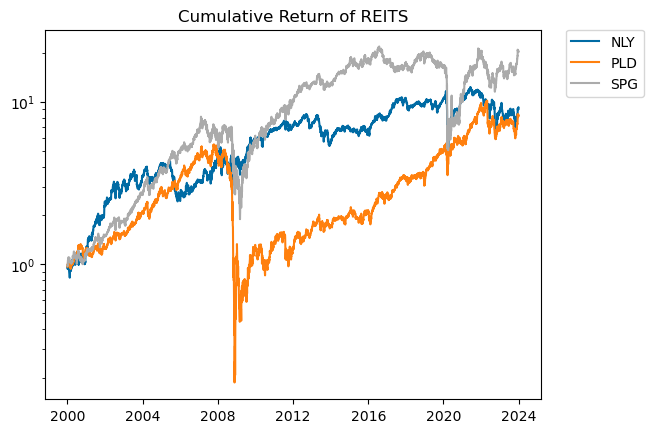

In [93]:
"""
https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html
"""
plt.style.use('tableau-colorblind10')

columns = ['NLY', 'PLD', 'SPG'] #Original file had hwp, but can't find the PEMNOS so replaced with GE
plt.plot((reit[columns]+1).cumprod(axis=0), label=columns)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
plt.title('Cumulative Return of REITS')
plt.yscale("log");

In [98]:
combined_df = returns.join([commod, reit, pe], how='inner')
combined_df = combined_df[combined_df.index >= '2006-11-01']

,MSFT,GE,CSCO,WMT,INTC,XOM,IBM,C,ORCL,T,...,SKM,ZION,NUE,GLD,GSG,NLY,PLD,SPG,APO,PSP
2006-11-01,0.003483,-0.005981,-0.001243,-0.008726,-0.014995,-0.005041,-0.005740,-0.001396,0.000000,-0.014307,...,0.034468,-0.013308,-0.018661,0.018592,0.000000,0.000000,-0.010906,-0.000824,0.005550,-0.017551
2006-11-02,-0.001388,-0.005444,-0.002075,-0.011464,-0.016175,0.001830,-0.001307,0.002795,-0.010828,0.007701,...,0.012846,-0.008950,0.001745,0.009126,-0.007317,0.003811,-0.021732,-0.017213,-0.028641,-0.003573
2006-11-03,-0.001390,0.001729,-0.011642,-0.015738,-0.003385,0.013485,-0.002945,-0.003016,-0.026820,-0.008818,...,0.002378,-0.010303,0.001393,0.006137,0.014988,0.016705,-0.014211,-0.013005,0.005406,0.003187
2006-11-06,0.003829,0.014380,0.038284,-0.000842,0.014993,0.010534,0.013018,0.012704,0.017998,0.017200,...,0.004349,0.009896,0.036174,-0.006581,0.008230,0.019417,0.009445,0.007863,0.003767,0.012708
2006-11-07,0.003814,0.007655,0.006483,0.003369,-0.000841,-0.005212,0.001620,0.005177,0.005525,0.000000,...,0.011811,0.011638,-0.017791,0.002424,-0.005762,0.015385,-0.006730,-0.014444,-0.004021,0.003137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,0.002267,0.000245,0.003381,0.002021,0.004621,0.026445,0.005466,0.006138,0.004473,0.002189,...,0.010531,0.003521,-0.006062,0.002998,0.018349,0.007165,0.003090,0.013321,0.007527,0.007439
2022-12-27,-0.007414,0.012838,0.001053,0.000278,-0.005749,0.013894,0.005436,0.002937,0.001608,0.008192,...,0.011843,0.008050,0.003380,0.008430,0.007112,0.000000,-0.002904,0.001611,-0.013074,-0.005274
2022-12-28,-0.010255,-0.010502,-0.009678,-0.017523,-0.015420,-0.016426,-0.016852,0.005181,-0.008027,-0.013001,...,-0.015918,-0.017813,-0.017211,-0.004506,-0.009416,-0.028457,-0.025068,-0.025741,-0.014036,-0.013786
2022-12-29,0.027630,0.021715,0.009135,0.006087,0.026233,0.007566,0.007427,0.012102,0.013320,0.012624,...,-0.011893,0.023139,-0.000894,0.005598,-0.002376,0.018764,0.031870,0.019642,0.016795,0.029032


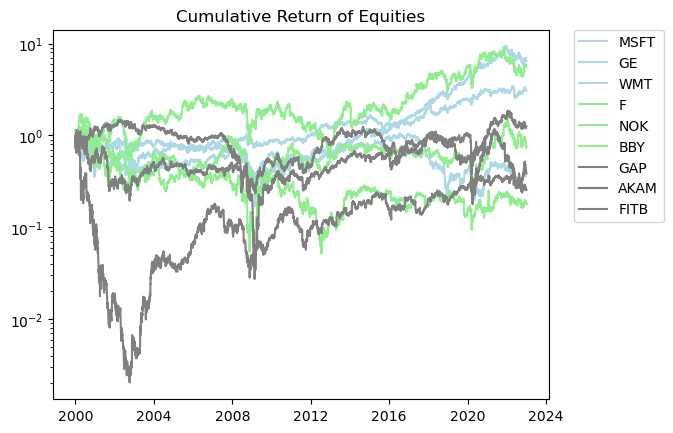

In [99]:
# Define custom colors for the specific groups of tickers
color_map = {
    'MSFT': 'lightblue', # large cap in blue
    'GE': 'lightblue',
    'WMT': 'lightblue',
    'F': 'lightgreen',   # mid cap in green
    'NOK': 'lightgreen',
    'BBY': 'lightgreen',
    'GAP': 'grey',       # small cap in grey
    'AKAM': 'grey',
    'FITB': 'grey'
}

# Plot cumulative returns for the selected columns with custom colors
columns = ['MSFT', 'GE', 'WMT', 'F', 'NOK', 'BBY', 'GAP', 'AKAM', 'FITB']

plt.style.use('tableau-colorblind10')

# Plot each column with the corresponding color
for col in columns:
    plt.plot((returns[col] + 1).cumprod(axis=0), label=col, color=color_map[col])

# Add legend and labels
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Cumulative Return of Equities')
plt.yscale("log")

# Show the plot
plt.show()


# Define Halflife Pairs
#### Specify the volatility halflife and covariance halflife for the EWMA

In [100]:
# provided
"""
rw_memory = rolling window size
    - reflect the number of trading days considered relevant.
    - 3 months = 60 days
    - 6 months = 125 days
    - 1 year = 250 days
ewma_halflife
iewma_pair = tuple (volatility halflife, covariance halflife) for a single iewma
cm_iewma_pairs = list of tuples of iewma_pairs
    - looks like the pairs are chosen to capture a variety of date ranges, from short term to 1 year
"""
rw_memory = 250
ewma_halflife=125
iewma_pair = (63,125)
cm_iewma_pairs = [(10, 21), (21, 63), (63, 125), (125, 250), (250, 500)]

# CM-IEWMA - Combined Multiple - Iterated Exponentially Weighted Moving Average


#### Start with IEWMA then combine it via SIGMA

In [101]:
# CM-IEWMA
iewmas = {f"{pair[0]}-{pair[1]}": list(iterated_ewma(returns, vola_halflife=pair[0], cov_halflife=pair[1], min_periods_vola=63, min_periods_cov=63)) for pair in cm_iewma_pairs}
Sigmas = {key: {item.time: item.covariance for item in iewma} for key, iewma in iewmas.items()}

# Regularize the covariance matrices for positive-definiteness
for i in range(len(cm_iewma_pairs)):
    fast = cm_iewma_pairs[i]; fast = f"{fast[0]}-{fast[1]}"
    Sigmas[fast] = add_to_diagonal(Sigmas[fast], lamda=0.05)

results = list(from_sigmas(Sigmas, returns, means=None).solve(window=10))

Running iterated_ewma
Running iterated_ewma
Running iterated_ewma


In [17]:
# check if eigen values are near 0
first_cov_matrix = list(Sigmas[fast].values())[0]

check = np.linalg.eig(first_cov_matrix)

check

(array([7.72463565e-02, 2.01382813e-02, 1.54390256e-02, 1.30293232e-02,
        1.14183551e-02, 1.09550356e-02, 1.01749617e-02, 8.80635384e-03,
        8.23826419e-03, 7.24704942e-03, 6.58600780e-03, 5.96737278e-03,
        5.69056786e-03, 4.93975391e-03, 4.85678285e-03, 4.47347789e-03,
        4.11076005e-03, 3.94610417e-03, 3.84483128e-03, 3.74432002e-03,
        3.45670042e-03, 3.18798329e-03, 2.97392429e-03, 2.58708777e-03,
        2.49802104e-03, 2.49004470e-03, 2.37756470e-03, 2.32001649e-03,
        2.22979808e-03, 1.99850755e-03, 1.93779119e-03, 1.88215484e-03,
        1.84898398e-03, 1.72891250e-03, 1.67401336e-03, 1.59077782e-03,
        1.48609289e-03, 1.44033697e-03, 1.41891497e-03, 1.25250839e-03,
        1.20726967e-03, 1.16332968e-03, 1.10134650e-03, 1.08508378e-03,
        1.00345691e-03, 9.50226426e-04, 8.87333339e-04, 8.48771035e-04,
        7.95918908e-04, 7.68603085e-04, 7.47606313e-04, 7.29545342e-04,
        6.78194673e-04, 6.67707379e-04, 6.24362213e-04, 6.359656

In [13]:
cm_iewma = {result.time: result.covariance for result in results}
weights = {result.time: result.weights for result in results}
# matches

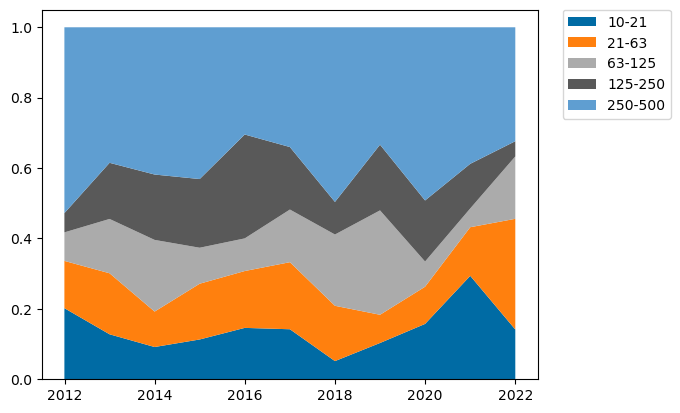

In [15]:
# Define start and end of backtest; first two years used for training/burn-in
start_date = pd.to_datetime("2011-12-28", format="%Y-%m-%d")
end_date = pd.to_datetime("2022-12-30", format="%Y-%m-%d")

quarterly_weights  = pd.DataFrame(weights).T.resample("Y").mean().loc[start_date:end_date]

plt.stackplot(quarterly_weights.index, quarterly_weights.values.T, labels=[f"{pair[0]}-{pair[1]}" for pair in cm_iewma_pairs])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.);

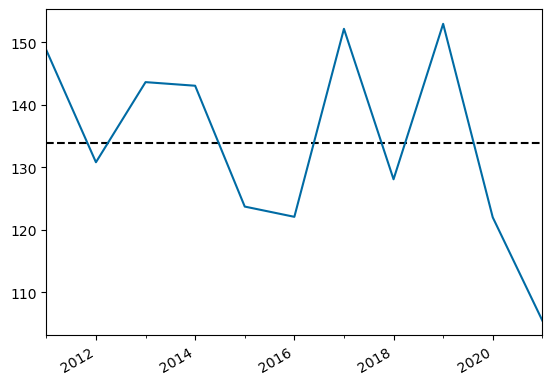

In [16]:
halflifes_vola = np.array([cm_iewma_pairs[i][0] for i in range(len(cm_iewma_pairs))])
(quarterly_weights * halflifes_vola).sum(axis=1).plot()
plt.axhline((quarterly_weights * halflifes_vola).sum(axis=1).mean(), color="black", linestyle="--", label="Mean half-life", zorder=-1);
plt.gcf().autofmt_xdate()

# Other Methods for Comparison

### Rolling Window Covariance Estimation

In [8]:
# general_functions: rolling_window #matches
rw = rolling_window(returns, rw_memory) 
# matches

### EWMA - Exponentially Weighted Moving Average

In [9]:
# ewma_functions: ewma #matches
ewma = dict(_ewma_cov(returns, halflife=ewma_halflife))
#matches

### IEWMA - Iterated Exponentially Weighted Moving Average

In [10]:
#ewma_functions: iterated_ewma  
iewma = list(iterated_ewma(returns, vola_halflife=iewma_pair[0],cov_halflife=iewma_pair[1]))
iewma = {iterate.time: iterate.covariance for iterate in iewma}
# matches

Running iterated_ewma


### MGARCH - Multivariate GARCH

In [11]:
mgarch_cond_cov = pd.read_csv("mgarch_predictors_from_R/stocks/mgarch_stocks_adj.csv", index_col=None)
Sigmas = from_row_matrix_to_covariance(mgarch_cond_cov.values, returns.shape[1]) / 10000

# Remove first year since it was used for training
times = returns.index[249:] 
mgarch = {times[t]: pd.DataFrame(Sigmas[t], index=returns.columns, columns=returns.columns) for t in range(Sigmas.shape[0])}

### Prescient (Perfect Foresight Covariance Matrix)

In [14]:
# Prescient 
prescient = {}
for t in returns.index:
    # get sample covariance matrix for corresponding quarter
    quarter = (t.month-1)//3 + 1
    cov = np.cov(returns.loc[(returns.index.year == t.year) & (returns.index.quarter == quarter)].values, rowvar=False)
    mean = np.mean(returns.loc[(returns.index.year == t.year) & (returns.index.quarter == quarter)].values, axis=0)
    prescient[t] = pd.DataFrame(cov+np.outer(mean, mean), index=returns.columns, columns=returns.columns)

# Backtests - MSE, Log-Likelihood, Regrets

### Presets

In [31]:
# Define start and end of backtest; first two years used for training/burn-in
start_date = pd.to_datetime("1971-06-24", format="%Y-%m-%d")
# start_date = pd.to_datetime("2010-01-04", format="%Y-%m-%d")
end_date = pd.to_datetime("2022-12-30", format="%Y-%m-%d")

In [20]:
names = ["RW", "EWMA", "IEWMA", "MGARCH", "CM-IEWMA", "Prescient"]

predictors_temp = [rw, ewma, iewma, mgarch, cm_iewma, prescient]
predictors = []

for predictor in predictors_temp:
    predictors.append({t: predictor[t] for t in predictor.keys() if t >= start_date and t <= end_date})

### MSE Calculation
##### Compares each method's predicted covariance matrix against actual realized covariances useing the MSE metric for each method on a quarterly basis (RW, EWMA, IEWMA, MGARCH, CM-IEWMA, Prescient)

In [21]:
for i, predictior in enumerate(predictors):
    MSE_temp = MSE(returns, predictior).resample("Q").mean()

    print("\n" + names[i])
    print(f"mean: {MSE_temp.mean():.6f}")
    print(f"std: {MSE_temp.std():.6f}")
    print(f"max: {MSE_temp.max():.6f}")


RW
mean: 0.000336
std: 0.001622
max: 0.010913

EWMA
mean: 0.000329
std: 0.001607
max: 0.010813

IEWMA
mean: 0.000324
std: 0.001580
max: 0.010626

MGARCH
mean: 0.000298
std: 0.001432
max: 0.009628

CM-IEWMA
mean: 0.000292
std: 0.001394
max: 0.009372

Prescient
mean: 0.000298
std: 0.001454
max: 0.009774


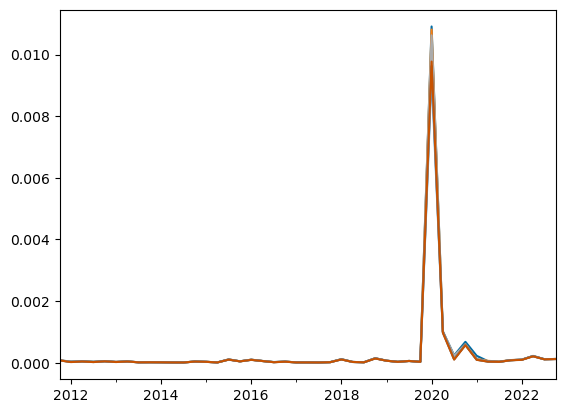

In [22]:
plt.figure()
for i, predictior in enumerate(predictors):
    MSE_temp = MSE(returns, predictior).resample("Q").mean()
    MSE_temp.plot()

### Log-Likelihood Calculation
##### Evaluate how well the covariance matrix fits the observed returns

In [24]:
log_likelihoods = {}

for i, predictor in enumerate(predictors):
    print("Computing " + names[i] + " log-likelihood...")
    returns_temp = returns.loc[pd.Series(predictor).index].values[1:]
    times = pd.Series(predictor).index[1:]
    Sigmas_temp = np.stack([predictor[t].values for t in predictor.keys()])[:-1]

    log_likelihoods[names[i]] = pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times)

regrets = {}
for name in log_likelihoods:
    regrets[name] =  log_likelihoods["Prescient"] - log_likelihoods[name]

Computing RW log-likelihood...
Computing EWMA log-likelihood...
Computing IEWMA log-likelihood...
Computing MGARCH log-likelihood...
Computing CM-IEWMA log-likelihood...
Computing Prescient log-likelihood...


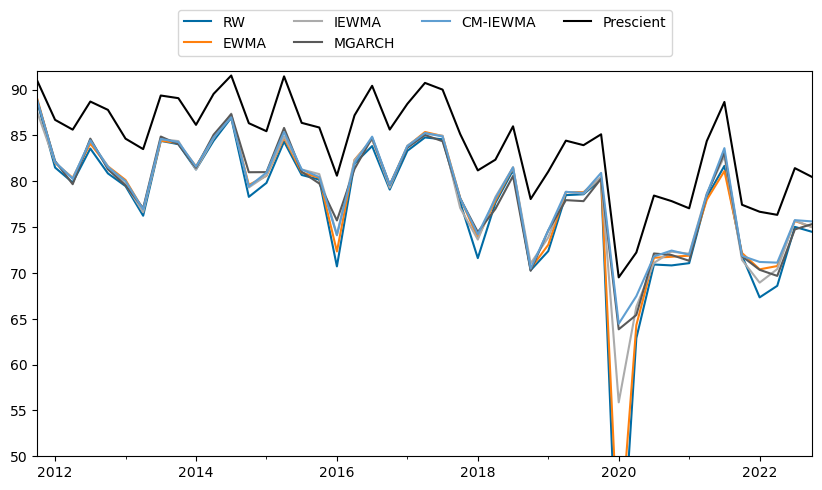

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for name in names:
    if name == 'Prescient':
        log_likelihoods[name].resample("Q").mean().plot(label=name, c="k")
    else:
        log_likelihoods[name].resample("Q").mean().plot(label=name)
plt.legend(bbox_to_anchor=(0.5, 1.1), loc='center', ncols=4, labels=names, scatterpoints=1, markerscale=5);
plt.ylim(50,92);

### Regrets Calculation 
##### Comparing the log-likelihood of each method against the prescient method (ideal benchmark)

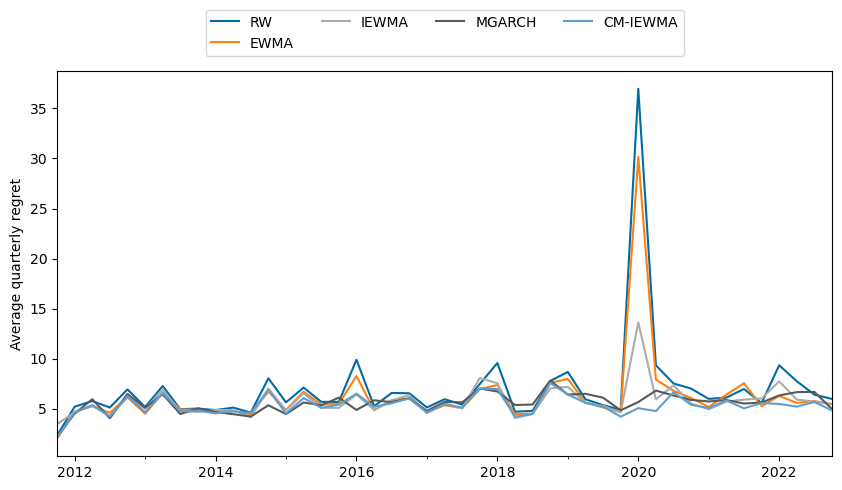

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for name in names:
    if name == 'Prescient':
        pass
    else:
        regrets[name].resample("Q").mean().plot(label=name)
plt.legend(bbox_to_anchor=(0.5, 1.1), loc='center', ncols=4, labels=names[:-1], scatterpoints=1, markerscale=5);
plt.ylabel("Average quarterly regret");


MGARCH vs CM-IEWMA Regret

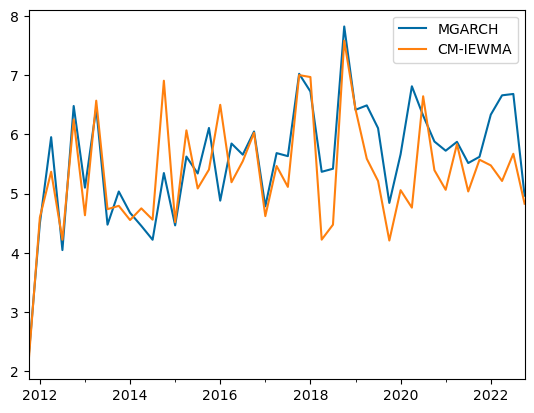

In [28]:
# MGARCH vs CM-IEWMA regret
regret_mgarch = regrets["MGARCH"].resample("Q").mean()
regret_cm_iewma = regrets["CM-IEWMA"].resample("Q").mean()

regret_mgarch.plot(label="MGARCH")
regret_cm_iewma.plot(label="CM-IEWMA");
plt.legend();

In [29]:
cm_iewma_advantage = (regret_cm_iewma - regret_mgarch < 0).mean()
print(f"CM-IEWMA is better than MGARCH {cm_iewma_advantage:.0%} of the time")

CM-IEWMA is better than MGARCH 71% of the time


Regret CDF

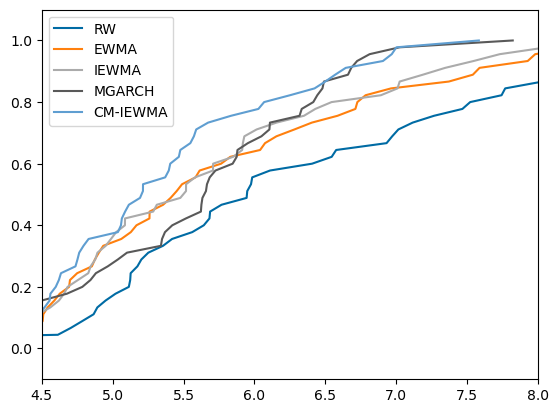

In [31]:
for name in log_likelihoods:
    if name != "Prescient":
        data = regrets[name].resample("Q").mean().values
        x, y = ecdf(data)
        plt.plot(x, y, label=name)
plt.xlim(4.5,8)
plt.ylim(-0.1,1.1)
plt.legend();

Regret Metrics

In [32]:
# Latex format
print("\\begin{tabular}{lccccc}")
print("   \\toprule")
print("   Predictor & Average & Std.~dev. & Max \\\\")
print("   \\midrule")

for name in regrets:
    if name != "PRESCIENT":
        print("   {}".format(name), end=" & ")
        regret = regrets[name].resample("Q").mean()
        avg = round(np.mean(regret), 1)  # Rounds float values
        std_dev = round(np.std(regret), 1)  # Rounds float values
        max_val = round(np.max(regret), 1)  # Rounds float values
        print("{} & {} & {} \\\\".format(avg, std_dev, max_val))

print("   \\hline")
print("   PRESCIENT & 0.0 & 0.0 & 0.0 \\\\")
print("   \\bottomrule")
print("\\end{tabular}")


\begin{tabular}{lccccc}
   \toprule
   Predictor & Average & Std.~dev. & Max \\
   \midrule
   RW & 7.0 & 4.8 & 37.0 \\
   EWMA & 6.2 & 3.8 & 30.2 \\
   IEWMA & 5.8 & 1.6 & 13.6 \\
   MGARCH & 5.6 & 1.0 & 7.8 \\
   CM-IEWMA & 5.3 & 1.0 & 7.6 \\
   Prescient & 0.0 & 0.0 & 0.0 \\
   \hline
   PRESCIENT & 0.0 & 0.0 & 0.0 \\
   \bottomrule
\end{tabular}


In [33]:
# python friendly format

import pandas as pd
import numpy as np

# Create a DataFrame to hold the table data
table_data = []

for name in regrets:
    if name != "PRESCIENT":
        # Ensure regret is a Series and handle any edge cases
        regret = regrets[name].resample("Q").mean()
        
        # Calculate metrics and use built-in round() for floats
        avg = round(np.mean(regret), 1)  # Rounds float values
        std_dev = round(np.std(regret), 1)  # Rounds float values
        max_val = round(np.max(regret), 1)  # Rounds float values
        
        # Append the results to table_data
        table_data.append([name, avg, std_dev, max_val])

# Add Prescient row manually
table_data.append(["PRESCIENT", 0.0, 0.0, 0.0])

# Create a DataFrame
columns = ['Predictor', 'Average', 'Std. dev.', 'Max']
df = pd.DataFrame(table_data, columns=columns)

# Display the DataFrame nicely
print(df)


   Predictor  Average  Std. dev.   Max
0         RW      7.0        4.8  37.0
1       EWMA      6.2        3.8  30.2
2      IEWMA      5.8        1.6  13.6
3     MGARCH      5.6        1.0   7.8
4   CM-IEWMA      5.3        1.0   7.6
5  Prescient      0.0        0.0   0.0
6  PRESCIENT      0.0        0.0   0.0


# Backtest - Portfolio Optimiztion

### Presets

In [35]:
#from cvx.backtest.portfolios import *

# Risk-free rate for backtest period; for cash allocation end_date removed since
# it is removed in returns (in shift(-1)) to make predictors causal
rf = rf_rate.loc[start_date:end_date].iloc[:-1]

# Portfolio paramaters
additonal_cons = {"short_lim":1.6, "upper_bound":0.15,\
             "lower_bound":-0.1}

#volatility target
sigma_tar = 0.1
excess = True

### Equally Weighted Portfolio

In [36]:
def yearly_SR(trader):
    rets = pd.Series(trader.rets.flatten(), index=trader.returns.index)

    means = rets.resample("Y").mean() * 252
    stds = rets.resample("Y").std() * np.sqrt(252)

    return means / stds

In [37]:
traders_eq_w = EqWeighted(returns, predictors, names, start_date, end_date).backtest()

100%|██████████| 6/6 [00:03<00:00,  1.68it/s]


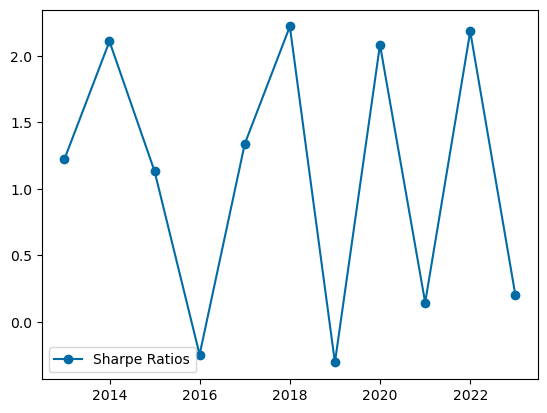

In [78]:
trader = traders_eq_w["CM-IEWMA"]
trader.get_total_returns()
SRs = yearly_SR(trader)

SRs_df=pd.DataFrame(SRs)
SRs_df.index=pd.to_datetime(SRs_df.index)
SRs_df.rename(columns={0: 'Srs'}, inplace=True)

filtered_SR = SRs_df[SRs_df.index >= '2012-01-01']
plt.plot(filtered_SR.index, filtered_SR['Srs'],label="Sharpe Ratios", marker='o')
plt.legend();

#doesn't quite match, maybe because of GE

In [79]:
create_table(traders_eq_w, sigma_tar, rf, excess)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   RW & 6.8\% & 10.6\% & 0.6 & 23\% \\
   EWMA & 6.4\% & 10.0\% & 0.6 & 21\% \\
   IEWMA & 6.7\% & 10.1\% & 0.7 & 20\% \\
   MGARCH & 7.2\% & 9.4\% & 0.8 & 15\% \\
   CM-IEWMA & 6.8\% & 9.6\% & 0.7 & 17\% \\
   \hline
   Prescient & 12.8\% & 9.9\% & 1.3 & 10\% \\
   \bottomrule
\end{tabular}


### Minimum Risk Portfolio

In [43]:
traders_min_risk = MinRisk(returns, [cm_iewma], ["CM-IEWMA"], start_date, end_date).backtest(additonal_cons)

  0%|          | 0/1 [00:00<?, ?it/s]


PicklingError: Can't pickle <class 'covariance_functions.tradingmodel_functions.Trader'>: it's not the same object as covariance_functions.tradingmodel_functions.Trader

In [ ]:
trader = traders_min_risk["CM-IEWMA"]
SRs = yearly_SR(trader)
plt.legend().remove()

In [ ]:
create_table(traders_min_risk, sigma_tar, rf, excess, prescient=False)

In [ ]:
# After 2010
create_table(traders_min_risk, sigma_tar, rf, excess, prescient=False)

In [ ]:
create_table(traders_min_risk, sigma_tar, rf, excess)

### Maximum Diversification Portfolio

In [ ]:
traders_max_diverse = MaxDiverse(returns, predictors, names, start_date, end_date).backtest(additonal_cons)

  0%|          | 0/6 [00:00<?, ?it/s]/Users/ziyuechen/anaconda3/envs/230X/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:356: FutureWarning: 
    You specified your problem should be solved by ECOS. Starting in
    CXVPY 1.6.0, ECOS will no longer be installed by default with CVXPY.
    Please either add ECOS as an explicit install dependency to your project
    or switch to our new default solver, Clarabel, by either not specifying a
    solver argument or specifying ``solver=cp.CLARABEL``. To suppress this
    warning while continuing to use ECOS, you can filter this warning using
    Python's ``warnings`` module until you are using 1.6.0.
    
  warnings.warn(ECOS_DEP_DEPRECATION_MSG, FutureWarning)
  0%|          | 0/6 [00:01<?, ?it/s]


PicklingError: Can't pickle <class 'covariance_functions.tradingmodel_functions.Trader'>: it's not the same object as covariance_functions.tradingmodel_functions.Trader

In [ ]:
create_table(traders_max_diverse, sigma_tar, rf, excess)

### Risk Parity Portfolio

In [ ]:
traders_risk_par = RiskParity(returns, predictors, names, start_date, end_date).backtest()

  0%|          | 0/6 [00:01<?, ?it/s]


PicklingError: Can't pickle <class 'covariance_functions.tradingmodel_functions.Trader'>: it's not the same object as covariance_functions.tradingmodel_functions.Trader

In [ ]:
create_table(traders_risk_par, sigma_tar, rf, excess)

In [ ]:
def tune_returns(returns):
    """
    Cuts element in each row at its 40th and 60th percentile
    up and down
    """
    
    returns_tuned = np.zeros_like(returns)

    for t in range(returns.shape[0]):
        r_temp = returns.iloc[t]
        returns_tuned[t] = np.clip(r_temp, a_min=r_temp.quantile(0.4), a_max=r_temp.quantile(0.6))

    return pd.DataFrame(returns_tuned, index=returns.index, columns=returns.columns)

### Mean Variance

In [35]:
from covariance_functions.portfolio_functions import MeanVariance

In [ ]:
r_hat_ewma1 = pd.DataFrame(dict(_ewma_mean(returns, halflife=1))).T
r_hat_ewma5 = pd.DataFrame(dict(_ewma_mean(returns, halflife=5))).T
r_hat_ewma10 = pd.DataFrame(dict(_ewma_mean(returns, halflife=10))).T
r_hat_ewma21 = pd.DataFrame(dict(_ewma_mean(returns, halflife=21))).T
r_hat_ewma63 = pd.DataFrame(dict(_ewma_mean(returns, halflife=63))).T

mean_predictors = [r_hat_ewma1, r_hat_ewma5, r_hat_ewma10, r_hat_ewma21, r_hat_ewma63]
cov_predictors = [cm_iewma for _ in range(len(mean_predictors))]

traders_mean_var = MeanVariance(returns, cov_predictors, ["1", "5", "10", "21", "63"], mean_predictors=mean_predictors, start_date=start_date, end_date=end_date).backtest(additonal_cons, sigma_tar)

In [ ]:
create_table(traders_mean_var, None, rf, excess, prescient=False)

In [ ]:
# 1-day EWMA from 2010
create_table(traders_mean_var, None, rf, excess, prescient=False)

In [ ]:
# 5-day EWMA from 2010
create_table(traders_mean_var, None, rf, excess, prescient=False)

In [ ]:
# 10-day EWMA from 2010
create_table(traders_mean_var, None, rf, excess, prescient=False)

In [ ]:
# 21-day EWMA from 2010
create_table(traders_mean_var, None, rf, excess, prescient=False)

In [ ]:
# 63-day EWMA from 2010
create_table(traders_mean_var, None, rf, excess, prescient=False)

In [ ]:
# 250-day EWMA from 2010
create_table(traders_mean_var, None, rf, excess, prescient=False)

In [ ]:
SRs.loc["2010-01-01":].mean()

In [ ]:
# 1-day EWMA
trader = traders_mean_var["1"]
trader.returns = trader.R
SRs = yearly_SR(trader)
plt.legend().remove()

In [ ]:
# 5-day EWMA
trader = traders_mean_var["5"]
trader.returns = trader.R
SRs = yearly_SR(trader)
plt.legend().remove()

In [ ]:
# 5-day EWMA
trader = traders_mean_var["63"]
trader.returns = trader.R
SRs = yearly_SR(trader)
plt.legend().remove()

In [ ]:
# 63-day EWMA
trader = traders_mean_var["CM-IEWMA"]
SRs = yearly_SR(trader)
plt.legend().remove()

In [ ]:
# 250-day EWMA
trader = traders_mean_var["CM-IEWMA"]
SRs = yearly_SR(trader)
plt.legend().remove()

In [ ]:
# 250-day EWMA plus clipping
trader = traders_mean_var["CM-IEWMA"]
SRs = yearly_SR(trader)
plt.legend().remove()

In [ ]:
# 250-day EWMA + clipping 
create_table(traders_mean_var, None, rf, excess, prescient=False)

In [ ]:
# 250-day EWMA 
create_table(traders_mean_var, None, rf, excess, prescient=False)

In [ ]:
create_table(traders_mean_var, None, rf, excess)